# 프로젝트 : 모든 장르 간 편향성 측정해 보기

- 지금까지 우리는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보았습니다. 
- 어느 정도는 우리의 상식과 일치하는 편향성이 측정되었을 것입니다.
- 이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 보겠습니다. 
- 대부분의 과정은 이전 스텝에서 이미 진행한 내용을 참고해서 동일하게 진행 가능할 것입니다.

### 순서
- STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
- STEP 2. 추출된 결과로 embedding model 만들기
- STEP 3. target, attribute 단어 셋 만들기
    - TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축
- STEP 4. WEAT score 계산과 시각화

### STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [1]:
#  synopsis.txt의 일부를 읽어보기

import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(5):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.


In [2]:
# synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장

from konlpy.tag import Okt
okt = Okt()
tokenized = []  #품사가 명사인 경우만 변수에 저장
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []  # 응답객체
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [3]:
print(len(tokenized))

71156


### STEP 2. 추출된 결과로 embedding model 만들기

In [4]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[('작품', 0.8827558755874634),
 ('다큐멘터리', 0.8424476981163025),
 ('드라마', 0.8220523595809937),
 ('영화로', 0.8014294505119324),
 ('코미디', 0.7963934540748596),
 ('형식', 0.7823663949966431),
 ('주제', 0.7719240784645081),
 ('소재', 0.7681858539581299),
 ('스토리', 0.7654461860656738),
 ('감동', 0.7644698619842529)]

In [5]:
model.wv.most_similar(positive=['사랑']) #positive 함수는 리스트를 입력값으로 받아 각각의 요소를 판별해서 양수 값만 돌려주는 함수

[('시빌라', 0.735916018486023),
 ('행복', 0.7099601626396179),
 ('첫사랑', 0.7000086307525635),
 ('애정', 0.6973126530647278),
 ('연애', 0.6898577213287354),
 ('진심', 0.6893284916877747),
 ('이별', 0.6888149380683899),
 ('토마슈', 0.6774667501449585),
 ('우정', 0.6749960780143738),
 ('운명', 0.6711017489433289)]

In [6]:
model.wv.most_similar(positive=['연극']) #positive 함수는 리스트를 입력값으로 받아 각각의 요소를 판별해서 양수 값만 돌려주는 함수

[('영화감독', 0.8787387609481812),
 ('시나리오', 0.8721884489059448),
 ('연기자', 0.8707054853439331),
 ('캐스팅', 0.8655997514724731),
 ('대본', 0.8593947291374207),
 ('영감', 0.8578363060951233),
 ('배우', 0.8576148152351379),
 ('연기', 0.8573223948478699),
 ('무용', 0.8491141200065613),
 ('행위예술', 0.8487892150878906)]

### STEP 3. target, attribute 단어 셋 만들기
이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

#### TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

In [7]:
# 'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고 명사 추출

import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: #fread 큰 용량의 외부 데이터도 빠르게 불러올 수 있다.
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, Adjective(형용사)", "Verb(동사)"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


- 참고 :  <a href="https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html" target="_blank"> KoNLPy 한국어 처리 패키지 품사 태그의 기호와 의미 tagset속성 </a>

In [8]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [10]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [11]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [12]:
#  우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [13]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [14]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [15]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [16]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [18]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

### STEP 4. WEAT score 계산과 시각화

영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

In [23]:
def cos_sim(i, j): #cos_sim 코사인 유사도
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)  # 단어 w에 대해 A 데이터셋의 단어들과 코사인유사도를 구한다.
    c_b = cos_sim(w, B)  # 단어 w에 대해 B 데이터셋의 단어들과 코사인유사도를 구한다.
    mean_A = np.mean(c_a, axis=-1)    #axis 축  attribute_A
    mean_B = np.mean(c_b, axis=-1)    #axis 축  attribute_B
    return mean_A - mean_B#, c_a, c_b

def weat_score(X, Y, A, B): #target X,Y,  attribute_A,B
    
    s_X = s(X, A, B)  #target X, attribute_A,B
    s_Y = s(Y, A, B)  #target Y, attribute_A,B

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0)) #concatenate 지정된 축에서 여러 배열을 연결
    
    return  (mean_X-mean_Y)/std_dev # (mean_X-mean_Y)/ std_dev 표준편차

In [24]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [25]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


In [26]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.5274163
SF 공연 -0.36098123
SF 공포(호러) -0.7014163
SF 기타 0.33562523
SF 다큐멘터리 0.60054183
SF 드라마 -0.3969465
SF 멜로로맨스 -0.8181302
SF 뮤지컬 0.32986102
SF 미스터리 -0.7044037
SF 범죄 -0.24783637
SF 사극 -0.8325307
SF 서부극(웨스턴) -0.40699613
SF 성인물(에로) -0.5845843
SF 스릴러 -0.5440561
SF 애니메이션 0.3521109
SF 액션 -0.45732436
SF 어드벤처 -0.7729824
SF 전쟁 0.24780746
SF 코미디 -0.4637294
SF 판타지 -0.18635456
가족 공연 0.24437188
가족 공포(호러) -0.13709043
가족 기타 0.74842685
가족 다큐멘터리 0.852551
가족 드라마 0.21610352
가족 멜로로맨스 -0.6208249
가족 뮤지컬 0.70571166
가족 미스터리 -0.28830597
가족 범죄 0.21986437
가족 사극 -0.0411063
가족 서부극(웨스턴) 0.50246793
가족 성인물(에로) -0.3057915
가족 스릴러 -0.12693135
가족 애니메이션 0.8587709
가족 액션 0.13731924
가족 어드벤처 0.02847328
가족 전쟁 0.6873275
가족 코미디 0.21005209
가족 판타지 0.44130406
공연 공포(호러) -0.2607531
공연 기타 0.880871
공연 다큐멘터리 0.919027
공연 드라마 -0.061011814
공연 멜로로맨스 -0.7352625
공연 뮤지컬 0.85068816
공연 미스터리 -0.36776474
공연 범죄 0.061224226
공연 사극 -0.36990634
공연 서부극(웨스턴) 0.041832846
공연 성인물(에로) -0.50603265
공연 스릴러 -0.23590615
공연 애니메이션 0.87732035
공연 액션 -0.03668

<AxesSubplot:>

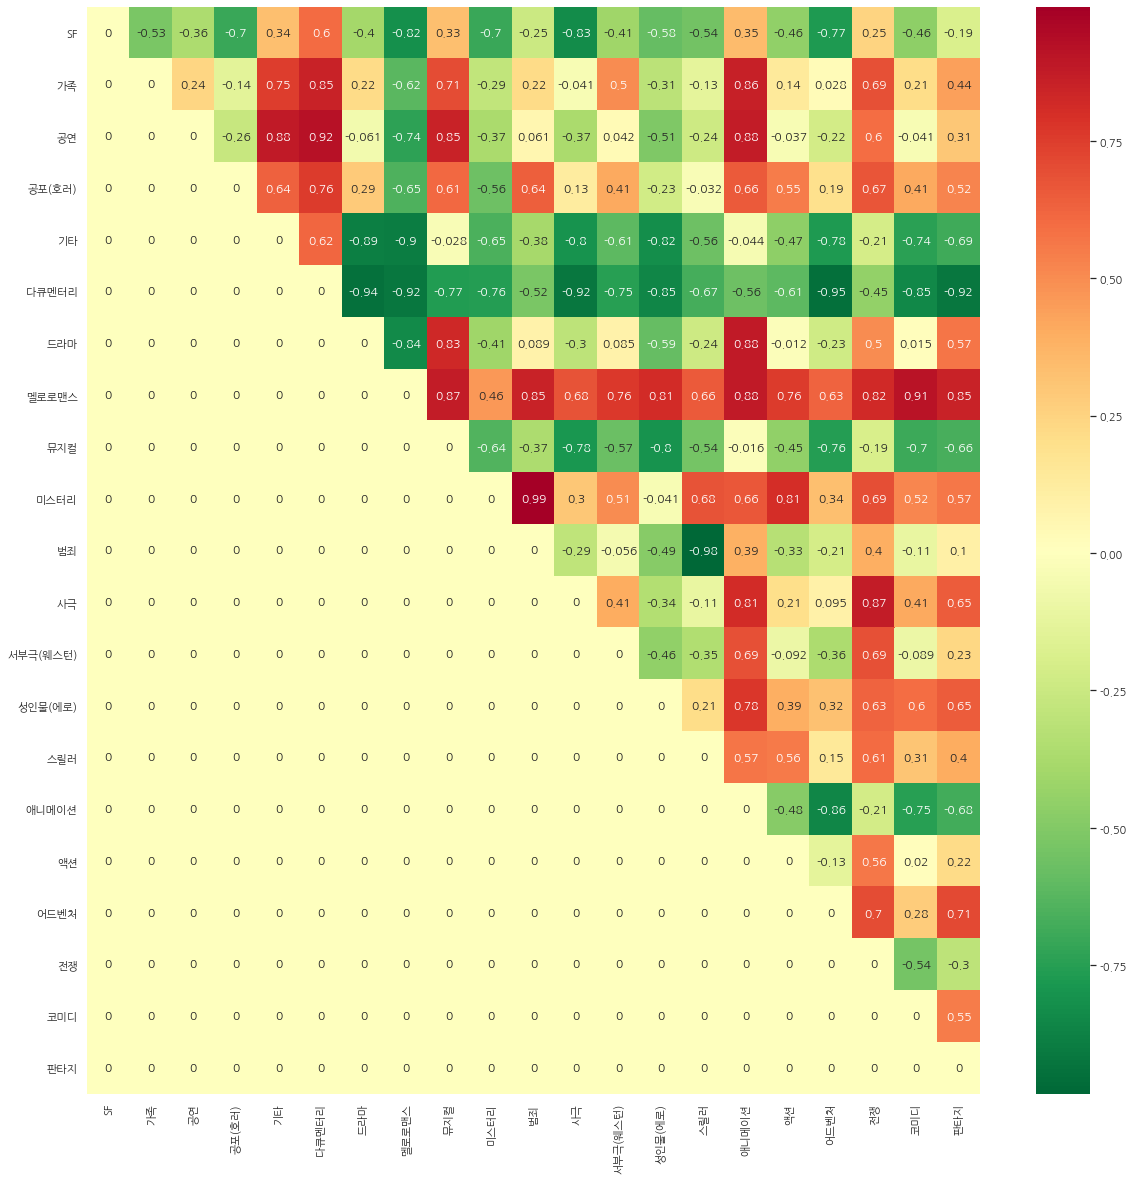

In [30]:
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,20))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

### 루브릭

- 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
- 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다
- 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

## 회고

- 1.  WEAT score과 관련한 삼각함수 관련 자료를 다시 찾아보았다.

    [WEAT score]
![weat](https://user-images.githubusercontent.com/70866993/136812373-7e6fd617-0d83-422f-844d-3548dd28425b.JPG)

    - target X, Y에 속하는 각 단어 x, y들이 개념축 A-B에 대해 가지는 편향성을 r각각 평균 내서 뺀 차이
    - 즉, X에 속하는 단어들과 Y에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정도가 뚜렷이 차이 날수록 이 WEAT score 식의 분자값의 절댓값은 커지게 됩니다. 
    - 이 값을 X, Y에 속하는 모든 단어들이 가지는 편향성 값의 표준편차(std)로 normalize한 값이 최종 WEAT score가 됩니다.

    [코사인유사도]

![코사인유사도](https://user-images.githubusercontent.com/70866993/136813940-096c5361-f4b6-4be8-97ad-c83c006f856f.png)
    - norm 벡터의 길이, dot 점곱
    - 코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미합니다.
    - 두 벡터의 방향이 완전히 동일한 경우에는 1의 값을 가지며, 90°의 각을 이루면 0, 180°로 반대의 방향을 가지면 -1의 값을 갖게 됩니다. 
    - 즉, 결국 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있습니다. 
    - 이를 직관적으로 이해하면 두 벡터가 가리키는 방향이 얼마나 유사한가를 의미합니다.


- 2. TF-IDF를 적용했을 때의 문제점
    - <단점>
        1) 문장의 순서가 중요한 문제에는 쓰기 힘들다.
        2) 단어간의 연관성을 표현하지 못한다.

    <개선>
    - LSA (Latent Semantic Analysis) : American restaurant menu, hamburger pizza 를 SVD로 서로간의 유사도 측정 -> 의미론적으로 같은 것들을 묶어준다.
    - Word Embedding (Word2Vec, Glove)
    - ConceptNet -> Knowledge graph를 이용, 여러가지의 단어간의 relationship을 사용 ex) Mcdonald, BurgerKing은 같은 햄버거를 다루는 레스토랑이며, 프랜차이즈이다. 이런 관계의 유사도를 측정.

###  TF-IDF를 적용했을 때의 문제점을 Word2Vec 보완
-  Word2Vec을 별도로 구현할 필요없이 파이썬의 gensim 패키지를 통해 이미 구현된 Word2Vec 모델을 사용

In [31]:
import nltk
nltk.download('abc')
nltk.download('punkt')

[nltk_data] Downloading package abc to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/abc.zip.
[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
from nltk.corpus import abc
corpus = abc.sents()
print("슝~")

슝~


In [33]:
from nltk.corpus import abc
corpus = abc.sents()
print("슝~")

슝~


In [34]:
print('코퍼스의 크기 :',len(corpus))

코퍼스의 크기 : 29059


In [35]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = corpus, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
print("모델 학습 완료!")

모델 학습 완료!


In [38]:
model_result = model.wv.most_similar("she")
print(model_result)

[('he', 0.9178735017776489), ('Bradstock', 0.7990259528160095), ('Buley', 0.795392632484436), ('Brownlee', 0.7680463790893555), ('Svenson', 0.7495509386062622), ('Brady', 0.7492104172706604), ('Zeil', 0.7344887256622314), ('Arcini', 0.7338216304779053), ('Fischer', 0.7320232391357422), ('systemic', 0.7274735569953918)]


In [39]:
from gensim.models import KeyedVectors

model.wv.save_word2vec_format('~/aiffel/word_embedding/w2v') 
loaded_model = KeyedVectors.load_word2vec_format("~/aiffel/word_embedding/w2v")
print("모델  load 완료!")

모델  load 완료!


In [41]:
model_result = loaded_model.most_similar("she")
print(model_result)

[('he', 0.9178735017776489), ('Bradstock', 0.7990259528160095), ('Buley', 0.795392632484436), ('Brownlee', 0.7680463790893555), ('Svenson', 0.7495509386062622), ('Brady', 0.7492104172706604), ('Zeil', 0.7344887256622314), ('Arcini', 0.7338216304779053), ('Fischer', 0.7320232391357422), ('systemic', 0.7274735569953918)]
